In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer
from sklearn.svm import SVC
import openai
import config
import json


In [2]:
df = pd.read_csv("ObesityDataSet_raw_and_data_sinthetic.csv")

In [3]:
df.head()

Gender   Age  Height  Weight family_history_with_overweight FAVC  FCVC  \
0  Female  21.0    1.62    64.0                            yes   no   2.0   
1  Female  21.0    1.52    56.0                            yes   no   3.0   
2    Male  23.0    1.80    77.0                            yes   no   2.0   
3    Male  27.0    1.80    87.0                             no   no   3.0   
4    Male  22.0    1.78    89.8                             no   no   2.0   

   NCP       CAEC SMOKE  CH2O  SCC  FAF  TUE        CALC  \
0  3.0  Sometimes    no   2.0   no  0.0  1.0          no   
1  3.0  Sometimes   yes   3.0  yes  3.0  0.0   Sometimes   
2  3.0  Sometimes    no   2.0   no  2.0  1.0  Frequently   
3  3.0  Sometimes    no   2.0   no  2.0  0.0  Frequently   
4  1.0  Sometimes    no   2.0   no  0.0  0.0   Sometimes   

                  MTRANS           NObeyesdad  
0  Public_Transportation        Normal_Weight  
1  Public_Transportation        Normal_Weight  
2  Public_Transportation        Normal_Weight  
3                Walking   Overweight_Level_I  
4  Public_Transportation  Overweight_Level_II

In [4]:
df.nunique()

Gender                               2
Age                               1402
Height                            1574
Weight                            1525
family_history_with_overweight       2
FAVC                                 2
FCVC                               810
NCP                                635
CAEC                                 4
SMOKE                                2
CH2O                              1268
SCC                                  2
FAF                               1190
TUE                               1129
CALC                                 4
MTRANS                               5
NObeyesdad                           7
dtype: int64

In [5]:
df["NObeyesdad"].value_counts()

Obesity_Type_I         351
Obesity_Type_III       324
Obesity_Type_II        297
Overweight_Level_I     290
Overweight_Level_II    290
Normal_Weight          287
Insufficient_Weight    272
Name: NObeyesdad, dtype: int64

In [6]:
category_mapping = {
    'Obesity_Type_I': 'obesity',
    'Obesity_Type_II': 'obesity',
    'Obesity_Type_III': 'obesity',
    'Overweight_Level_I': 'overweight',
    'Overweight_Level_II': 'overweight',
    'Normal_Weight': 'normal_weight',
    'Insufficient_Weight': 'underweight'
}

In [7]:
df['Category_type'] = df['NObeyesdad'].map(category_mapping)

In [8]:
df.columns

Index(['Gender', 'Age', 'Height', 'Weight', 'family_history_with_overweight',
       'FAVC', 'FCVC', 'NCP', 'CAEC', 'SMOKE', 'CH2O', 'SCC', 'FAF', 'TUE',
       'CALC', 'MTRANS', 'NObeyesdad', 'Category_type'],
      dtype='object')

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2111 entries, 0 to 2110
Data columns (total 18 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Gender                          2111 non-null   object 
 1   Age                             2111 non-null   float64
 2   Height                          2111 non-null   float64
 3   Weight                          2111 non-null   float64
 4   family_history_with_overweight  2111 non-null   object 
 5   FAVC                            2111 non-null   object 
 6   FCVC                            2111 non-null   float64
 7   NCP                             2111 non-null   float64
 8   CAEC                            2111 non-null   object 
 9   SMOKE                           2111 non-null   object 
 10  CH2O                            2111 non-null   float64
 11  SCC                             2111 non-null   object 
 12  FAF                             21

(array([287.,   0.,   0., 580.,   0.,   0., 972.,   0.,   0., 272.]),
 array([0. , 0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.1, 2.4, 2.7, 3. ]),
 <BarContainer object of 10 artists>)

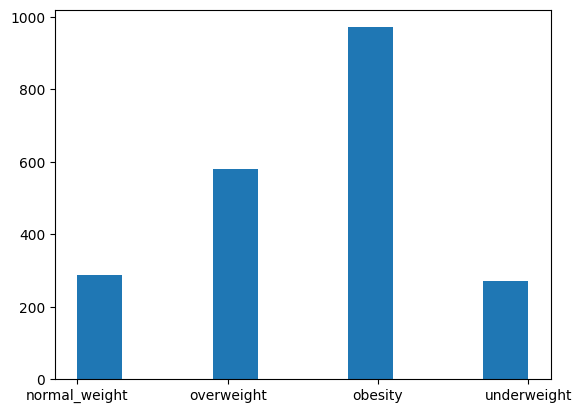

In [10]:
plt.hist(df["Category_type"])

because of categorizing 7 types into 4 we have imbalance data.

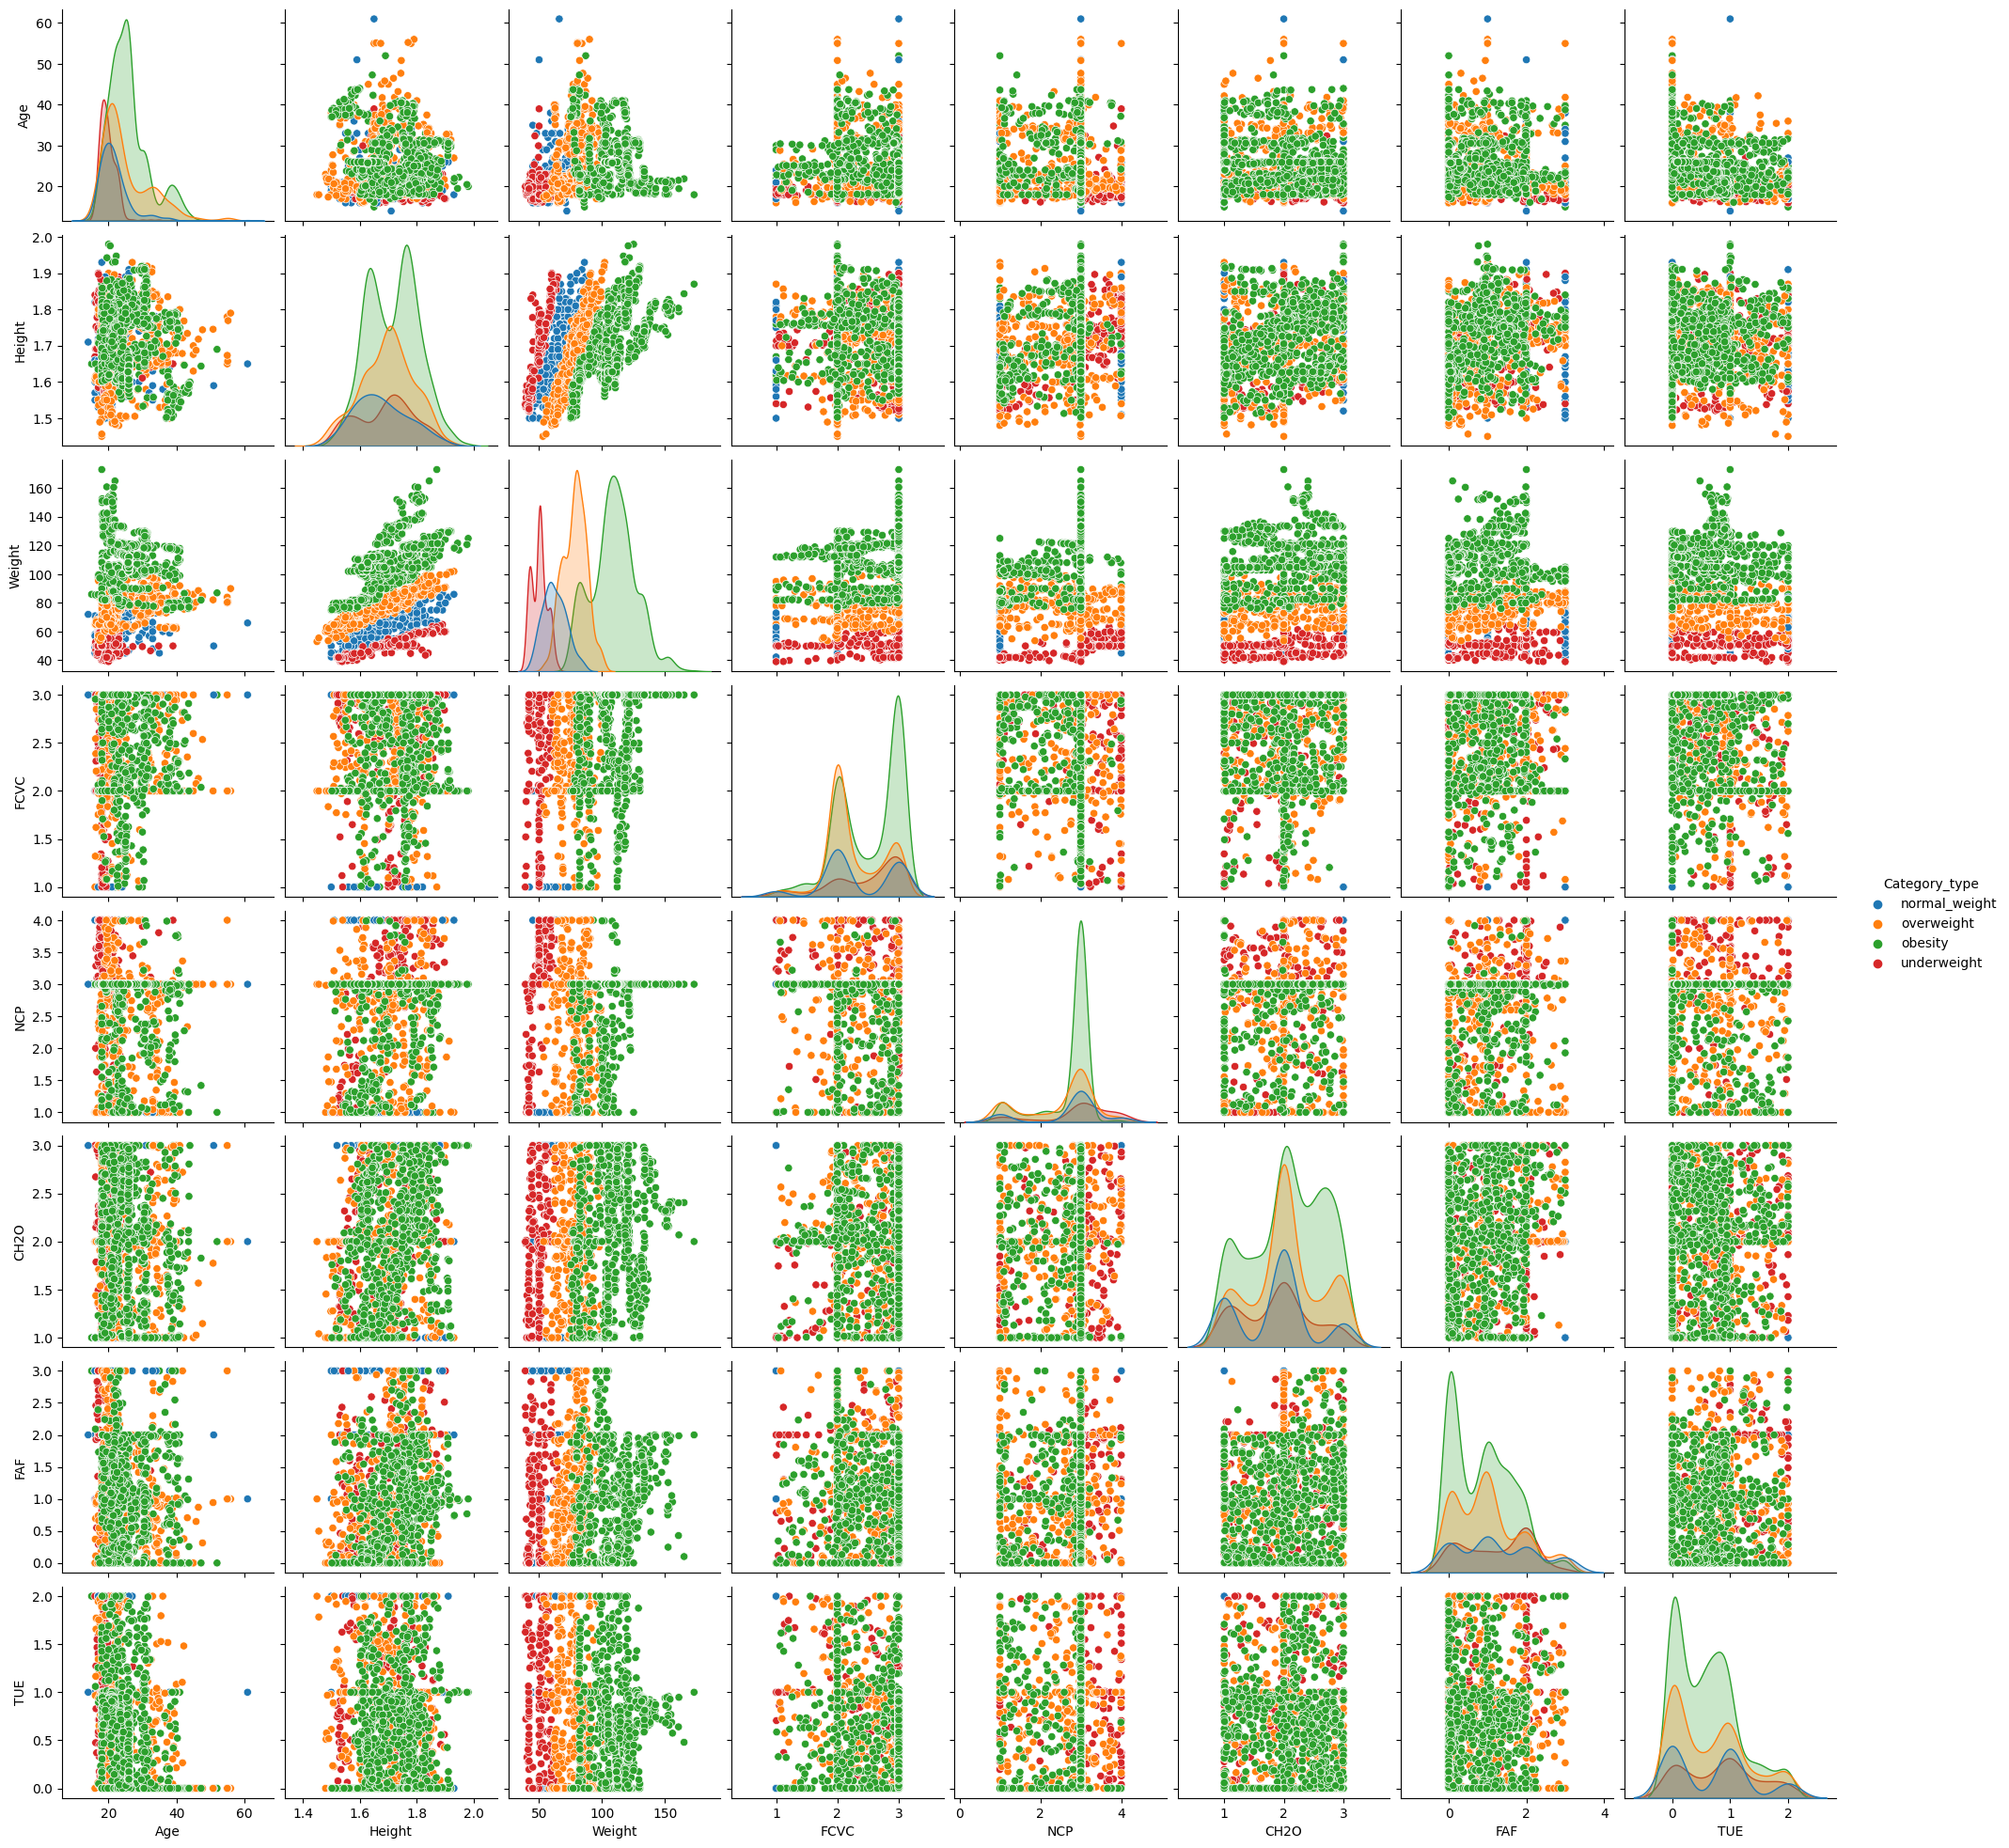

In [11]:
sns.pairplot(df, hue="Category_type")

In [12]:
df.columns

Index(['Gender', 'Age', 'Height', 'Weight', 'family_history_with_overweight',
       'FAVC', 'FCVC', 'NCP', 'CAEC', 'SMOKE', 'CH2O', 'SCC', 'FAF', 'TUE',
       'CALC', 'MTRANS', 'NObeyesdad', 'Category_type'],
      dtype='object')

In [13]:

# Convert 'Category_type' to codes
df['Category_type_encoded'] = df['Category_type'].astype('category').cat.codes


numerical_correlation = df[['Age', 'Height', 'Weight', 'FCVC', 'NCP', 'CH2O', 'FAF', 'TUE', 'Category_type_encoded']].corr(method='pearson')
categorical_correlation = pd.DataFrame(index=['Category_type_encoded'], columns=['Gender', 'family_history_with_overweight', 'FAVC', 'CAEC', 'SMOKE', 'SCC', 'CALC', 'MTRANS'])

for col in categorical_correlation.columns:
    confusion_mat = pd.crosstab(df['Category_type'], df[col])
    chi2, _, _, _ = stats.chi2_contingency(confusion_mat)
    n = confusion_mat.sum().sum()
    cramers_v = np.sqrt(chi2 / (n * (min(confusion_mat.shape) - 1)))
    categorical_correlation.loc['Category_type_encoded_c', col] = cramers_v
correlation_matrix = pd.concat([numerical_correlation, categorical_correlation.transpose()], axis=0)


In [14]:
correlation_matrix["Category_type_corelation_score"] = correlation_matrix["Category_type_encoded"].fillna(0) + correlation_matrix["Category_type_encoded_c"].fillna(0)
correlation_matrix.drop(["Category_type_encoded", "Category_type_encoded_c"], inplace = True, axis=1)
correlation_matrix

Age    Height    Weight      FCVC  \
Age                             1.000000 -0.025958  0.202560  0.016291   
Height                         -0.025958  1.000000  0.463136 -0.038121   
Weight                          0.202560  0.463136  1.000000  0.216125   
FCVC                            0.016291 -0.038121  0.216125  1.000000   
NCP                            -0.043944  0.243672  0.107469  0.042216   
CH2O                           -0.045304  0.213376  0.200575  0.068461   
FAF                            -0.144938  0.294709 -0.051436  0.019939   
TUE                            -0.296931  0.051912 -0.071561 -0.101135   
Category_type_encoded          -0.102718 -0.011333 -0.367647 -0.033275   
Gender                               NaN       NaN       NaN       NaN   
family_history_with_overweight       NaN       NaN       NaN       NaN   
FAVC                                 NaN       NaN       NaN       NaN   
CAEC                                 NaN       NaN       NaN       NaN   
SMOKE                                NaN       NaN       NaN       NaN   
SCC                                  NaN       NaN       NaN       NaN   
CALC                                 NaN       NaN       NaN       NaN   
MTRANS                               NaN       NaN       NaN       NaN   

                                     NCP      CH2O       FAF       TUE  \
Age                            -0.043944 -0.045304 -0.144938 -0.296931   
Height                          0.243672  0.213376  0.294709  0.051912   
Weight                          0.107469  0.200575 -0.051436 -0.071561   
FCVC                            0.042216  0.068461  0.019939 -0.101135   
NCP                             1.000000  0.057088  0.129504  0.036326   
CH2O                            0.057088  1.000000  0.167236  0.011965   
FAF                             0.129504  0.167236  1.000000  0.058562   
TUE                             0.036326  0.011965  0.058562  1.000000   
Category_type_encoded           0.001036 -0.008295  0.038602  0.081648   
Gender                               NaN       NaN       NaN       NaN   
family_history_with_overweight       NaN       NaN       NaN       NaN   
FAVC                                 NaN       NaN       NaN       NaN   
CAEC                                 NaN       NaN       NaN       NaN   
SMOKE                                NaN       NaN       NaN       NaN   
SCC                                  NaN       NaN       NaN       NaN   
CALC                                 NaN       NaN       NaN       NaN   
MTRANS                               NaN       NaN       NaN       NaN   

                                Category_type_corelation_score  
Age                                                  -0.102718  
Height                                               -0.011333  
Weight                                               -0.367647  
FCVC                                                 -0.033275  
NCP                                                   0.001036  
CH2O                                                 -0.008295  
FAF                                                   0.038602  
TUE                                                   0.081648  
Category_type_encoded                                 1.000000  
Gender                                                0.123498  
family_history_with_overweight                        0.522162  
FAVC                                                  0.297247  
CAEC                                                  0.336019  
SMOKE                                                 0.081150  
SCC                                                   0.194236  
CALC                                                  0.119429  
MTRANS                                                0.153978

From the above correlation matrix we can see there is good correlation between these variables:
<br>
Weight and Category_type_corelation_score(target variable)<br>
Gender and Category_type_corelation_score(target variable)<br>
family_history_with_overweight and Category_type_corelation_score(target variable)<br>
FAVC and Category_type_corelation_score(target variable)<br>
CAEC and Category_type_corelation_score(target variable)<br>
SCC and Category_type_corelation_score(target variable)<br>
CALC and Category_type_corelation_score(target variable)<br>
MTRANS and Category_type_corelation_score(target variable)<br>


In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2111 entries, 0 to 2110
Data columns (total 19 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Gender                          2111 non-null   object 
 1   Age                             2111 non-null   float64
 2   Height                          2111 non-null   float64
 3   Weight                          2111 non-null   float64
 4   family_history_with_overweight  2111 non-null   object 
 5   FAVC                            2111 non-null   object 
 6   FCVC                            2111 non-null   float64
 7   NCP                             2111 non-null   float64
 8   CAEC                            2111 non-null   object 
 9   SMOKE                           2111 non-null   object 
 10  CH2O                            2111 non-null   float64
 11  SCC                             2111 non-null   object 
 12  FAF                             21

### Looking at the Distribution of all correlated variables with target variable

<Axes: xlabel='Category_type', ylabel='count'>

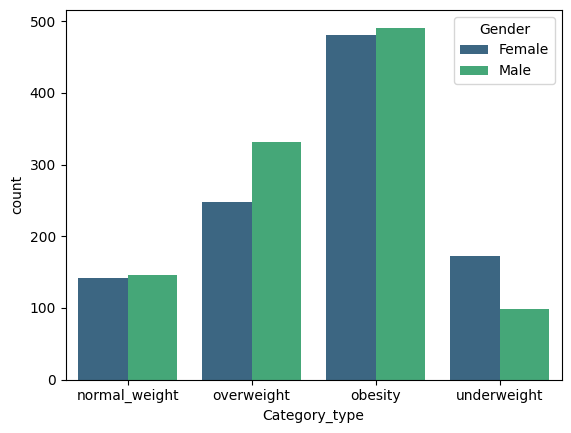

In [16]:
sns.countplot(x='Category_type', hue='Gender', data=df, palette='viridis')


<Axes: xlabel='Category_type', ylabel='count'>

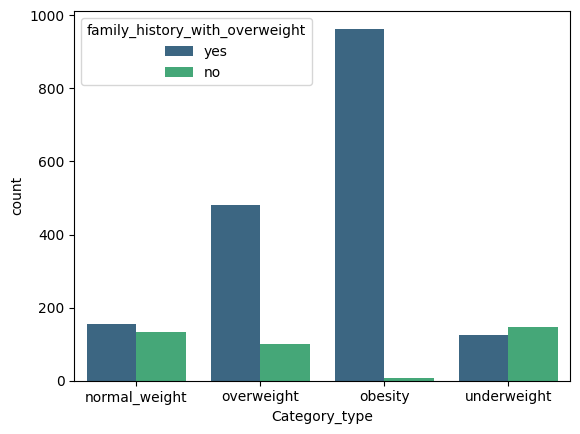

In [17]:
sns.countplot(x= "Category_type", hue="family_history_with_overweight", data=df, palette='viridis')

<Axes: xlabel='Category_type', ylabel='Weight'>

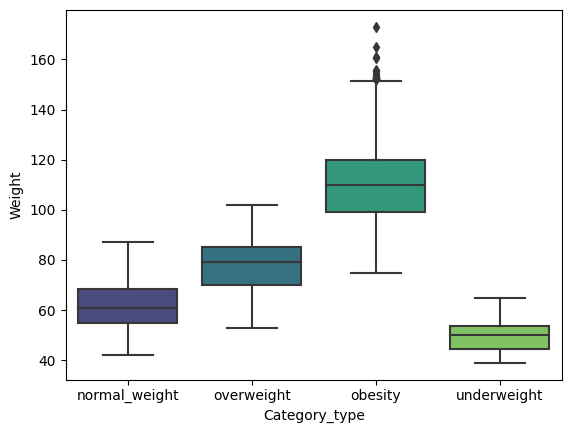

In [18]:
sns.boxplot(x='Category_type', y='Weight', data=df, palette='viridis')

<Axes: xlabel='Category_type', ylabel='count'>

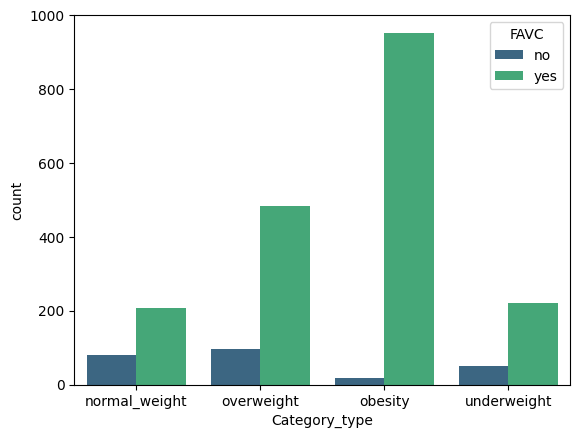

In [19]:
#  Frequent consumption of high caloric food
sns.countplot(x='Category_type', hue='FAVC', data=df, palette='viridis')

<Axes: xlabel='Category_type', ylabel='count'>

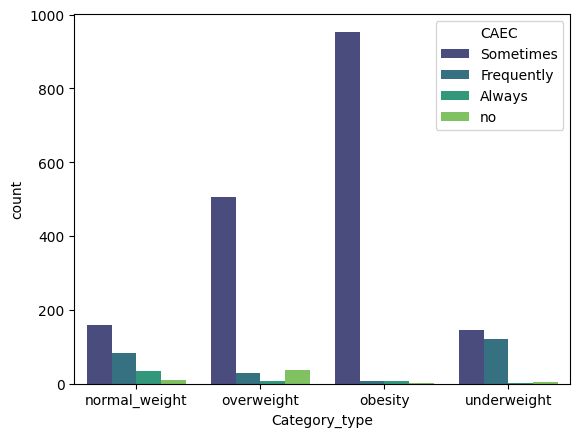

In [20]:
# Consumption of food between meals
sns.countplot(x='Category_type', hue='CAEC', data=df, palette='viridis')

<Axes: xlabel='Category_type', ylabel='count'>

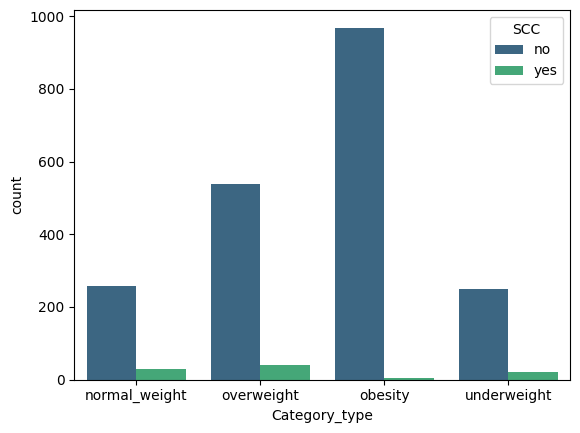

In [21]:
# Calories consumption monitoring
sns.countplot(x='Category_type', hue='SCC', data=df, palette='viridis')

<Axes: xlabel='Category_type', ylabel='count'>

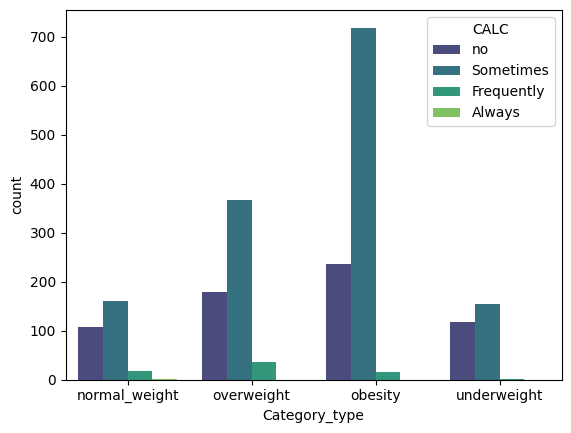

In [22]:
# Consumption of alcohol
sns.countplot(x='Category_type', hue='CALC', data=df, palette='viridis')

<Axes: xlabel='Category_type', ylabel='count'>

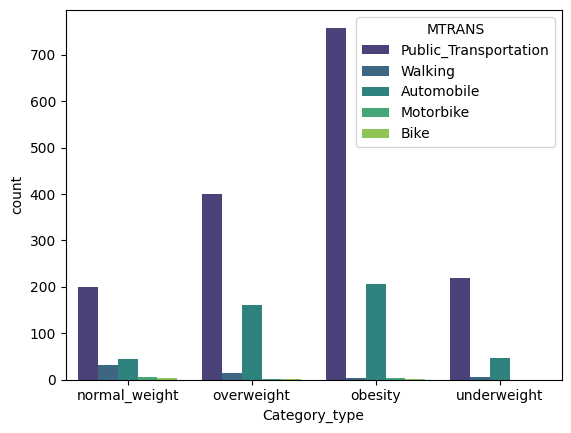

In [23]:
# Transportation used
sns.countplot(x='Category_type', hue='MTRANS', data=df, palette='viridis')

In [24]:

categorical = ["Gender", "family_history_with_overweight", "FAVC", "CAEC", "SMOKE", "SCC", "CALC", "MTRANS"]
df[categorical].nunique()

Gender                            2
family_history_with_overweight    2
FAVC                              2
CAEC                              4
SMOKE                             2
SCC                               2
CALC                              4
MTRANS                            5
dtype: int64

In [25]:
numerical = ["Age", "Height", "Weight", "FCVC", "NCP", "CH2O", "FAF", "TUE"]
df[numerical].nunique()

Age       1402
Height    1574
Weight    1525
FCVC       810
NCP        635
CH2O      1268
FAF       1190
TUE       1129
dtype: int64

### Dealing with categorical variables by using one hot encoding.

In [26]:
df_encoded = pd.get_dummies(df, columns=categorical)
df_encoded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2111 entries, 0 to 2110
Data columns (total 34 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   Age                                 2111 non-null   float64
 1   Height                              2111 non-null   float64
 2   Weight                              2111 non-null   float64
 3   FCVC                                2111 non-null   float64
 4   NCP                                 2111 non-null   float64
 5   CH2O                                2111 non-null   float64
 6   FAF                                 2111 non-null   float64
 7   TUE                                 2111 non-null   float64
 8   NObeyesdad                          2111 non-null   object 
 9   Category_type                       2111 non-null   object 
 10  Category_type_encoded               2111 non-null   int8   
 11  Gender_Female                       2111 no

In [27]:
df_encoded[numerical].head()

Age  Height  Weight  FCVC  NCP  CH2O  FAF  TUE
0  21.0    1.62    64.0   2.0  3.0   2.0  0.0  1.0
1  21.0    1.52    56.0   3.0  3.0   3.0  3.0  0.0
2  23.0    1.80    77.0   2.0  3.0   2.0  2.0  1.0
3  27.0    1.80    87.0   3.0  3.0   2.0  2.0  0.0
4  22.0    1.78    89.8   2.0  1.0   2.0  0.0  0.0

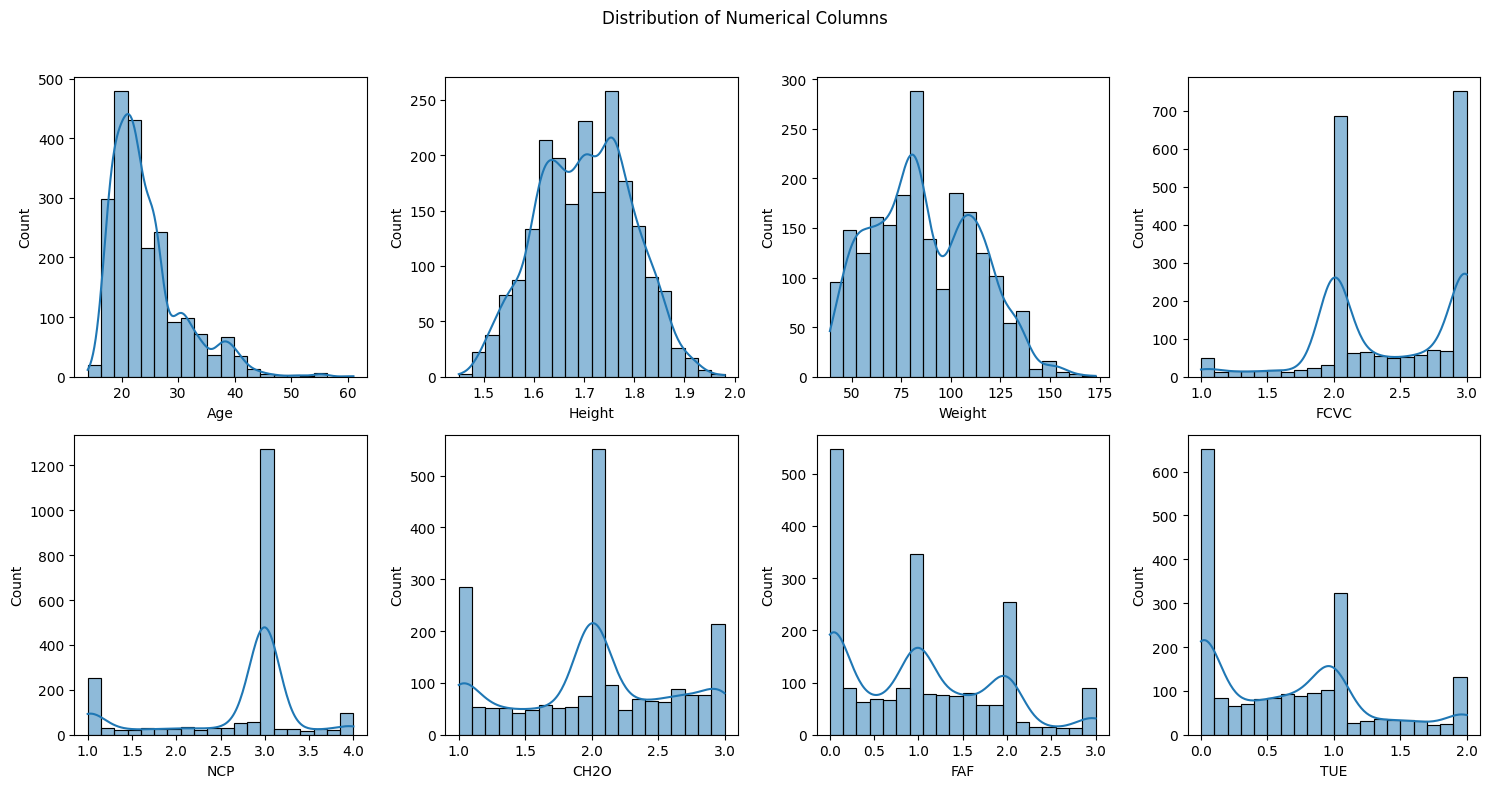

In [28]:
numerical_columns = ["Age", "Height", "Weight", "FCVC", "NCP", "CH2O", "FAF", "TUE"]
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(15, 8))
fig.suptitle('Distribution of Numerical Columns')
for i, col in enumerate(numerical_columns):
    sns.histplot(df[col], bins=20, kde=True, ax=axes[i // 4, i % 4])
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

### Some of the numerical columns are not in normal distribution and we have converted categorical variables into binary using one hot encoder. so scaling data using StandardScaler(Z-score Normalization) seems to be a good idea. But scaling data does not neseccarily convert data into normal distribution. So we will check the distribution of data after scaling.

In [29]:
df_normalized = df_encoded.copy()
scaler = StandardScaler()
df_normalized[numerical_columns] = scaler.fit_transform(df_encoded[numerical_columns])



In [30]:
df_normalized.head()

Age    Height    Weight      FCVC       NCP      CH2O       FAF  \
0 -0.522124 -0.875589 -0.862558 -0.785019  0.404153 -0.013073 -1.188039   
1 -0.522124 -1.947599 -1.168077  1.088342  0.404153  1.618759  2.339750   
2 -0.206889  1.054029 -0.366090 -0.785019  0.404153 -0.013073  1.163820   
3  0.423582  1.054029  0.015808  1.088342  0.404153 -0.013073  1.163820   
4 -0.364507  0.839627  0.122740 -0.785019 -2.167023 -0.013073 -1.188039   

        TUE           NObeyesdad  Category_type  ...  SCC_yes  CALC_Always  \
0  0.561997        Normal_Weight  normal_weight  ...        0            0   
1 -1.080625        Normal_Weight  normal_weight  ...        1            0   
2  0.561997        Normal_Weight  normal_weight  ...        0            0   
3 -1.080625   Overweight_Level_I     overweight  ...        0            0   
4 -1.080625  Overweight_Level_II     overweight  ...        0            0   

   CALC_Frequently  CALC_Sometimes  CALC_no  MTRANS_Automobile  MTRANS_Bike  \
0                0               0        1                  0            0   
1                0               1        0                  0            0   
2                1               0        0                  0            0   
3                1               0        0                  0            0   
4                0               1        0                  0            0   

   MTRANS_Motorbike  MTRANS_Public_Transportation  MTRANS_Walking  
0                 0                             1               0  
1                 0                             1               0  
2                 0                             1               0  
3                 0                             0               1  
4                 0                             1               0  

[5 rows x 34 columns]

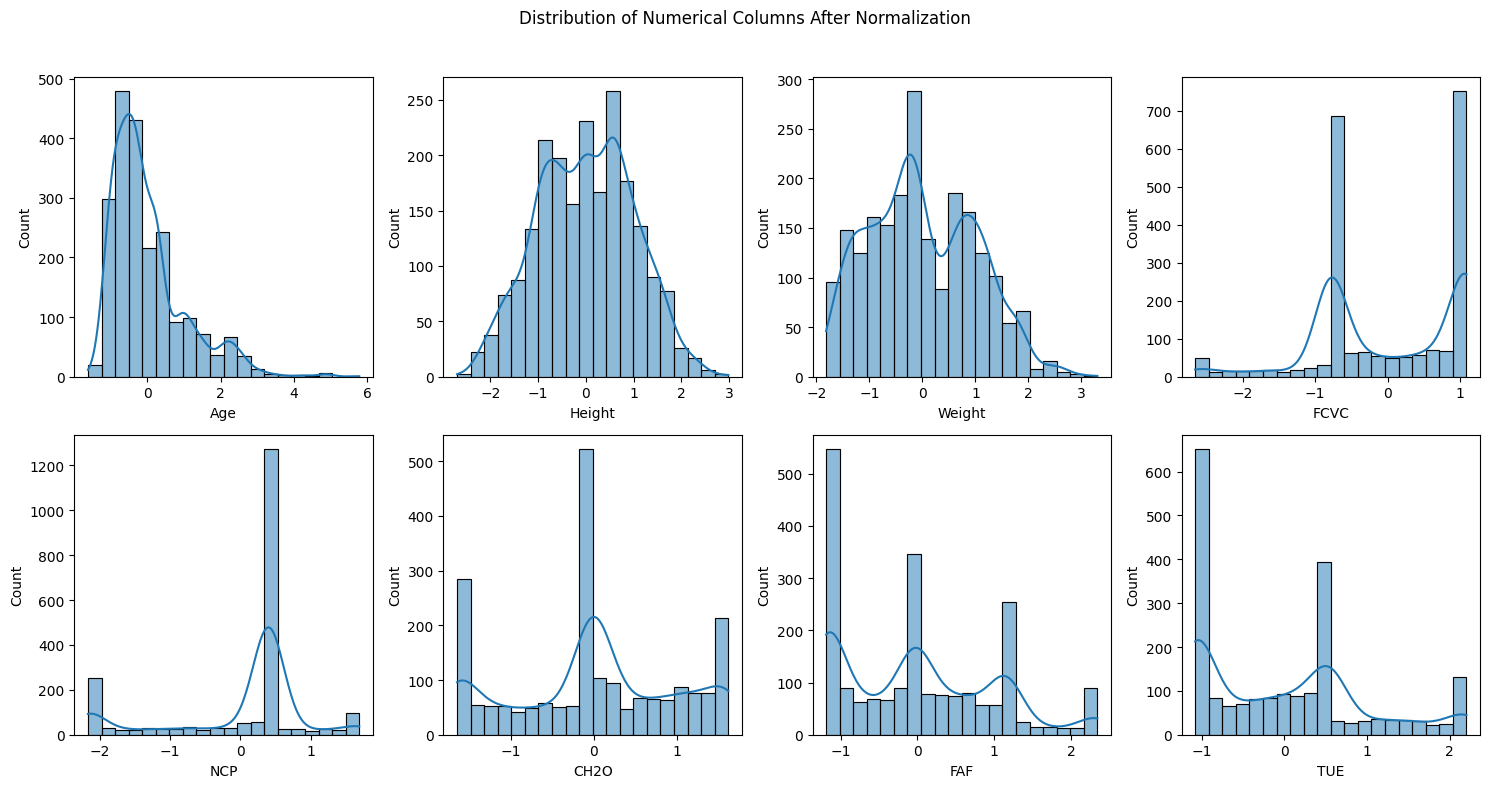

In [31]:
numerical_columns = ["Age", "Height", "Weight", "FCVC", "NCP", "CH2O", "FAF", "TUE"]
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(15, 8))
fig.suptitle('Distribution of Numerical Columns After Normalization')
for i, col in enumerate(numerical_columns):
    sns.histplot(df_normalized[col], bins=20, kde=True, ax=axes[i // 4, i % 4])
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

### Scaling of data did not convert data into normal distribution.

In [32]:
df_normalized

Age    Height    Weight      FCVC       NCP      CH2O       FAF  \
0    -0.522124 -0.875589 -0.862558 -0.785019  0.404153 -0.013073 -1.188039   
1    -0.522124 -1.947599 -1.168077  1.088342  0.404153  1.618759  2.339750   
2    -0.206889  1.054029 -0.366090 -0.785019  0.404153 -0.013073  1.163820   
3     0.423582  1.054029  0.015808  1.088342  0.404153 -0.013073  1.163820   
4    -0.364507  0.839627  0.122740 -0.785019 -2.167023 -0.013073 -1.188039   
...        ...       ...       ...       ...       ...       ...       ...   
2106 -0.525774  0.097045  1.711763  1.088342  0.404153 -0.456705  0.783135   
2107 -0.367195  0.502844  1.800914  1.088342  0.404153 -0.004702  0.389341   
2108 -0.281909  0.541672  1.798868  1.088342  0.404153  0.075361  0.474971   
2109  0.007776  0.404927  1.785780  1.088342  0.404153  1.377801  0.151471   
2110 -0.102119  0.398344  1.790592  1.088342  0.404153  1.396035  0.018996   

           TUE           NObeyesdad  Category_type  ...  SCC_yes  CALC_Always  \
0     0.561997        Normal_Weight  normal_weight  ...        0            0   
1    -1.080625        Normal_Weight  normal_weight  ...        1            0   
2     0.561997        Normal_Weight  normal_weight  ...        0            0   
3    -1.080625   Overweight_Level_I     overweight  ...        0            0   
4    -1.080625  Overweight_Level_II     overweight  ...        0            0   
...        ...                  ...            ...  ...      ...          ...   
2106  0.407996     Obesity_Type_III        obesity  ...        0            0   
2107 -0.096251     Obesity_Type_III        obesity  ...        0            0   
2108 -0.019018     Obesity_Type_III        obesity  ...        0            0   
2109 -0.117991     Obesity_Type_III        obesity  ...        0            0   
2110  0.092432     Obesity_Type_III        obesity  ...        0            0   

      CALC_Frequently  CALC_Sometimes  CALC_no  MTRANS_Automobile  \
0                   0               0        1                  0   
1                   0               1        0                  0   
2                   1               0        0                  0   
3                   1               0        0                  0   
4                   0               1        0                  0   
...               ...             ...      ...                ...   
2106                0               1        0                  0   
2107                0               1        0                  0   
2108                0               1        0                  0   
2109                0               1        0                  0   
2110                0               1        0                  0   

      MTRANS_Bike  MTRANS_Motorbike  MTRANS_Public_Transportation  \
0               0                 0                             1   
1               0                 0                             1   
2               0                 0                             1   
3               0                 0                             0   
4               0                 0                             1   
...           ...               ...                           ...   
2106            0                 0                             1   
2107            0                 0                             1   
2108            0                 0                             1   
2109            0                 0                             1   
2110            0                 0                             1   

      MTRANS_Walking  
0                  0  
1                  0  
2                  0  
3                  1  
4                  0  
...              ...  
2106               0  
2107               0  
2108               0  
2109               0  
2110               0  

[2111 rows x 34 columns]

In [33]:
df_normalized.drop(["NObeyesdad", "Category_type"], inplace=True, axis=1)

### splitting the data.

In [34]:
X = df_normalized.drop("Category_type_encoded", axis=1)
y = df_normalized["Category_type_encoded"]

In [35]:
df_normalized_80_percent, df_normalized_20_percent = train_test_split(df_normalized, test_size=0.2, random_state=42)

In [36]:
df_normalized_80_percent.to_csv("df_normalized_80_percent.csv", index=False)
df_normalized_20_percent.to_csv("df_normalized_20_percent.csv", index=False)

In [37]:
X_train, X_test, y_train, y_test = train_test_split(
    df_normalized_80_percent.drop('Category_type_encoded', axis=1),
    df_normalized_80_percent['Category_type_encoded'],
    test_size=0.2,
    random_state=42
)


Decision Trees

Random Forest

Support Vector Machines (SVM)

K-Nearest Neighbors (KNN)

ChatGPT 3.5 Turbo

Stratagy : 

We will first build a model using all of the data and then we will use cross validation with Hyper-parameter tuning and randomize data forevery kth iteration to see if we can improve the model.

## Decision Trees

Initial model.

In [38]:
df[["Category_type", "Category_type_encoded"]].drop_duplicates()

Category_type  Category_type_encoded
0   normal_weight                      0
3      overweight                      2
10        obesity                      1
59    underweight                      3

In [39]:
decision_tree_inital_model = DecisionTreeClassifier(random_state=42)
decision_tree_inital_model.fit(X_train, y_train)
y_pred = decision_tree_inital_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)
print(f"Accuracy: {accuracy}")
print("\nClassification Report:")
print(report)

Accuracy: 0.9467455621301775

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.76      0.83        42
           1       0.98      0.99      0.98       150
           2       0.92      0.96      0.94        99
           3       0.92      0.96      0.94        47

    accuracy                           0.95       338
   macro avg       0.93      0.92      0.92       338
weighted avg       0.95      0.95      0.95       338



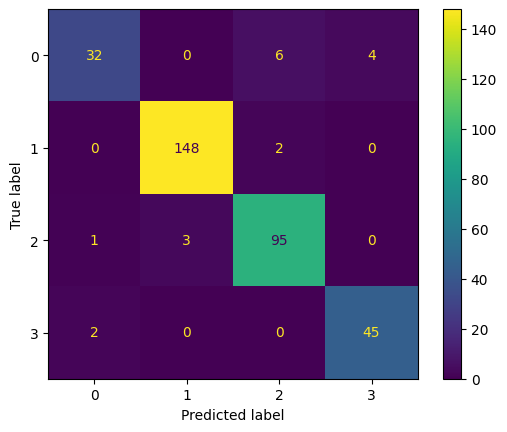

In [40]:
y_test_array = y_test.values
y_pred_array = y_pred

# Compute confusion matrix
cm = confusion_matrix(y_test_array, y_pred_array, labels=decision_tree_inital_model.classes_)

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=decision_tree_inital_model.classes_)
disp.plot()

Second model with hyper-parameter tuning at every cross validation splits.

In [41]:
decision_tree_cross_val_model = DecisionTreeClassifier(random_state=42)

hyperparameters = {
    'max_depth': [None, 5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}
stratified_kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)



From the above data exploration we know that we have imbalance data. I feel that F1 score is a good metric to evaluate the model for imbalence datasets. So we will use weighted F1 score(f1_weighted) to evaluate the model for each iteration.

In [42]:
decision_tree_best_models_list = []
for train_index, test_index in stratified_kfold.split(df_normalized_80_percent, df_normalized_80_percent['Category_type_encoded']):
    np.random.shuffle(train_index)
    np.random.shuffle(test_index)
    X_train1, X_test1 = df_normalized_80_percent.iloc[train_index], df_normalized_80_percent.iloc[test_index]
    y_train1, y_test1 = X_train1['Category_type_encoded'], X_test1['Category_type_encoded']
    X_train1, X_test1 = X_train1.drop('Category_type_encoded', axis=1), X_test1.drop('Category_type_encoded', axis=1)
    grid_search = GridSearchCV(decision_tree_cross_val_model, hyperparameters, scoring='f1_weighted', cv=5)
    grid_search.fit(X_train1, y_train1)
    best_model = grid_search.best_estimator_
    best_model.fit(X_train1, y_train1)

    train_accuracy = best_model.score(X_train1, y_train1)
    test_accuracy = best_model.score(X_test1, y_test1)
    y_pred1 = best_model.predict(X_test1)
    weighted_f1_scores = f1_score(y_test1, y_pred1, average="weighted")
    dict = {"best_model": best_model, "train_accuracy": train_accuracy,
            "test_accuracy": test_accuracy, "weighted_f1_scores": weighted_f1_scores, "best_hyperparameters" : grid_search.best_params_}
    decision_tree_best_models_list.append(dict)


In [43]:
decision_tree_best_models_list

[{'best_model': DecisionTreeClassifier(min_samples_leaf=4, random_state=42),
  'train_accuracy': 0.9809084924292297,
  'test_accuracy': 0.9585798816568047,
  'weighted_f1_scores': 0.9586154058238426,
  'best_hyperparameters': {'max_depth': None,
   'min_samples_leaf': 4,
   'min_samples_split': 2}},
 {'best_model': DecisionTreeClassifier(min_samples_leaf=2, random_state=42),
  'train_accuracy': 0.9927583936800527,
  'test_accuracy': 0.9349112426035503,
  'weighted_f1_scores': 0.9362572105823346,
  'best_hyperparameters': {'max_depth': None,
   'min_samples_leaf': 2,
   'min_samples_split': 2}},
 {'best_model': DecisionTreeClassifier(max_depth=10, min_samples_leaf=2, random_state=42),
  'train_accuracy': 0.9888084265964451,
  'test_accuracy': 0.9467455621301775,
  'weighted_f1_scores': 0.9477766041367974,
  'best_hyperparameters': {'max_depth': 10,
   'min_samples_leaf': 2,
   'min_samples_split': 2}},
 {'best_model': DecisionTreeClassifier(min_samples_leaf=4, random_state=42),
  'train

In [44]:
decision_tree_train_accuracies = [dicti['train_accuracy'] for dicti in decision_tree_best_models_list]
decision_tree_test_accuracies = [dicti['test_accuracy'] for dicti in decision_tree_best_models_list]
decision_tree_weighted_f1_scores = [dicti['weighted_f1_scores'] for dicti in decision_tree_best_models_list]

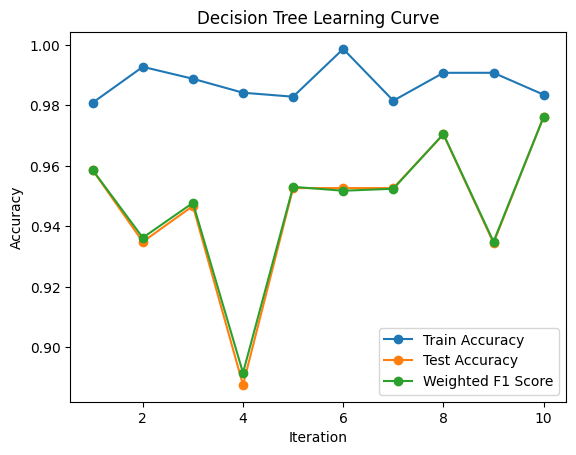

In [45]:
plt.plot(range(1, len(decision_tree_best_models_list) + 1), decision_tree_train_accuracies, marker='o', label='Train Accuracy')
plt.plot(range(1, len(decision_tree_best_models_list) + 1), decision_tree_test_accuracies, marker='o', label='Test Accuracy')
plt.plot(range(1, len(decision_tree_best_models_list) + 1), decision_tree_weighted_f1_scores, marker='o', label='Weighted F1 Score')
plt.title('Decision Tree Learning Curve')
plt.xlabel('Iteration')
plt.ylabel('Accuracy')
plt.legend()

From the above Chart we can see the models performance at every cross-validation iteration and we can see their train, test and f1_weighted scores. both test accuracy and weighted f1 scores are similar. So we can say that our model is not overfitting and we will consider best f1_scored model as the best of the best models.

In [46]:
max_f1_score = 0
max_f1_score_index = 0
for i, dict in enumerate(decision_tree_best_models_list):
    if max_f1_score < dict['weighted_f1_scores']:
        max_f1_score = dict['weighted_f1_scores']
        max_f1_score_index = i
    else :
        continue

In [47]:
best_decision_tree_final_pred = (decision_tree_best_models_list[max_f1_score_index]["best_model"]).predict(df_normalized_20_percent.drop("Category_type_encoded", axis=1))

In [48]:
print(classification_report(df_normalized_20_percent["Category_type_encoded"], best_decision_tree_final_pred))

              precision    recall  f1-score   support

           0       0.93      0.81      0.86        62
           1       1.00      0.98      0.99       199
           2       0.89      0.96      0.93       106
           3       0.93      1.00      0.97        56

    accuracy                           0.95       423
   macro avg       0.94      0.94      0.94       423
weighted avg       0.95      0.95      0.95       423



In [49]:
accuracy_score(df_normalized_20_percent["Category_type_encoded"], best_decision_tree_final_pred)

0.9527186761229315

## Random Forest

for all of the future models we will use the same strategy as we used for Decision Trees. and we will keep df_normalized_20_percent aside(completely unseen data) as our test data and we will use df_normalized_80_percent as our training data and for cross validation.

In [50]:
X_train, X_test, y_train, y_test = train_test_split(
    df_normalized_80_percent.drop('Category_type_encoded', axis=1),
    df_normalized_80_percent['Category_type_encoded'],
    test_size=0.2,
    random_state=42
)
random_forest_initial_model = RandomForestClassifier(random_state=42)
random_forest_initial_model.fit(X_train, y_train)
y_pred_random_forest_initial_model = random_forest_initial_model.predict(X_test)
print("Initial Random Forest Model Evaluation:")
print("Accuracy:", accuracy_score(y_test, y_pred_random_forest_initial_model))
print("\nClassification Report:")
print(classification_report(y_test, y_pred_random_forest_initial_model))

Initial Random Forest Model Evaluation:
Accuracy: 0.9467455621301775

Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.88      0.84        42
           1       0.99      0.98      0.99       150
           2       0.92      0.94      0.93        99
           3       1.00      0.91      0.96        47

    accuracy                           0.95       338
   macro avg       0.93      0.93      0.93       338
weighted avg       0.95      0.95      0.95       338



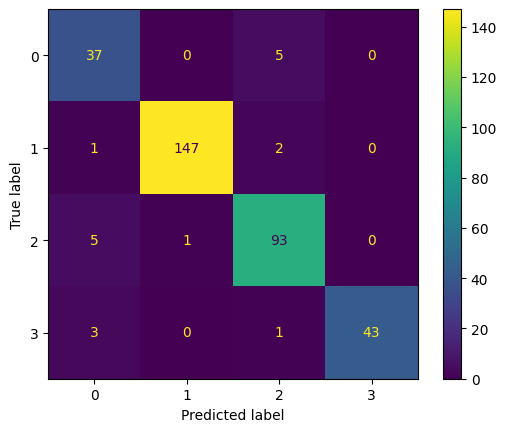

In [51]:
y_test_array = y_test.values
y_pred_array = y_pred_random_forest_initial_model
cm = confusion_matrix(y_test_array, y_pred_array, labels=decision_tree_inital_model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=decision_tree_inital_model.classes_)
disp.plot()

Second model with hyper-parameter tuning at every cross validation splits.

In [52]:
random_forest_cross_val_model = RandomForestClassifier(random_state=42)
hyperparameters_rf = {
    'n_estimators': [50, 100, 150],
    'max_depth': [None, 5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

stratified_kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

In [53]:
# Takes 10 - 15 minutes to run
random_forest_best_models_list = []
for train_index, test_index in stratified_kfold.split(df_normalized_80_percent, df_normalized_80_percent['Category_type_encoded']):
    np.random.shuffle(train_index)
    np.random.shuffle(test_index)
    X_train1, X_test1 = df_normalized_80_percent.iloc[train_index], df_normalized_80_percent.iloc[test_index]
    y_train1, y_test1 = X_train1['Category_type_encoded'], X_test1['Category_type_encoded']
    X_train1, X_test1 = X_train1.drop('Category_type_encoded', axis=1), X_test1.drop('Category_type_encoded', axis=1)
    grid_search = GridSearchCV(
        random_forest_cross_val_model,
        hyperparameters_rf,
        scoring='f1_weighted',
        cv=5
    )
    grid_search.fit(X_train1, y_train1)
    best_model = grid_search.best_estimator_
    best_model.fit(X_train1, y_train1)
    train_accuracy = best_model.score(X_train1, y_train1)
    test_accuracy = best_model.score(X_test1, y_test1)
    y_pred1 = best_model.predict(X_test1)
    weighted_f1_scores = f1_score(y_test1, y_pred1, average='weighted')
    result_dict = {
        "best_model": best_model,
        "train_accuracy": train_accuracy,
        "test_accuracy": test_accuracy,
        "weighted_f1_scores": weighted_f1_scores,
        "best_hyperparameters": grid_search.best_params_
    }
    random_forest_best_models_list.append(result_dict)

In [54]:
random_forest_best_models_list

[{'best_model': RandomForestClassifier(max_depth=15, random_state=42),
  'train_accuracy': 1.0,
  'test_accuracy': 0.9585798816568047,
  'weighted_f1_scores': 0.9587577831921724,
  'best_hyperparameters': {'max_depth': 15,
   'min_samples_leaf': 1,
   'min_samples_split': 2,
   'n_estimators': 100}},
 {'best_model': RandomForestClassifier(n_estimators=50, random_state=42),
  'train_accuracy': 1.0,
  'test_accuracy': 0.9112426035502958,
  'weighted_f1_scores': 0.9126940717115247,
  'best_hyperparameters': {'max_depth': None,
   'min_samples_leaf': 1,
   'min_samples_split': 2,
   'n_estimators': 50}},
 {'best_model': RandomForestClassifier(n_estimators=150, random_state=42),
  'train_accuracy': 1.0,
  'test_accuracy': 0.9704142011834319,
  'weighted_f1_scores': 0.9709995357607853,
  'best_hyperparameters': {'max_depth': None,
   'min_samples_leaf': 1,
   'min_samples_split': 2,
   'n_estimators': 150}},
 {'best_model': RandomForestClassifier(max_depth=15, n_estimators=150, random_state=

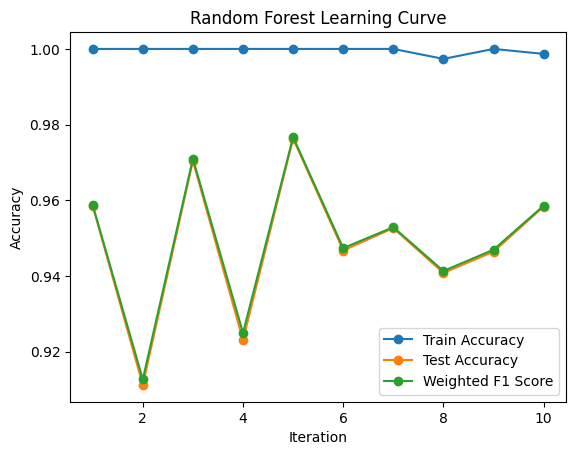

In [55]:
random_forest_train_accuracies = [dicti['train_accuracy'] for dicti in random_forest_best_models_list]
random_forest_test_accuracies = [dicti['test_accuracy'] for dicti in random_forest_best_models_list]
random_forest_weighted_f1_scores = [dicti['weighted_f1_scores'] for dicti in random_forest_best_models_list]

plt.plot(range(1, len(random_forest_best_models_list) + 1), random_forest_train_accuracies, marker='o', label='Train Accuracy')
plt.plot(range(1, len(random_forest_best_models_list) + 1), random_forest_test_accuracies, marker='o', label='Test Accuracy')
plt.plot(range(1, len(random_forest_best_models_list) + 1), random_forest_weighted_f1_scores, marker='o', label='Weighted F1 Score')
plt.title('Random Forest Learning Curve')
plt.xlabel('Iteration')
plt.ylabel('Accuracy')
plt.legend()

In [56]:
best_random_forest_model_pred = (random_forest_best_models_list[random_forest_weighted_f1_scores.index(max(random_forest_weighted_f1_scores))]["best_model"]).predict(df_normalized_20_percent.drop("Category_type_encoded", axis=1))

In [57]:
print("Accuracy:", accuracy_score(df_normalized_20_percent["Category_type_encoded"], best_random_forest_model_pred))
print(classification_report(df_normalized_20_percent["Category_type_encoded"], best_random_forest_model_pred))

Accuracy: 0.9432624113475178
              precision    recall  f1-score   support

           0       0.88      0.82      0.85        62
           1       0.98      0.98      0.98       199
           2       0.88      0.93      0.91       106
           3       0.98      0.96      0.97        56

    accuracy                           0.94       423
   macro avg       0.93      0.93      0.93       423
weighted avg       0.94      0.94      0.94       423



## SVM

Initial Model

In [58]:
svc_initial_model = SVC(random_state=42)
svc_initial_model.fit(X_train, y_train)
train_accuracy_initial = svc_initial_model.score(X_train, y_train)
test_accuracy_initial = svc_initial_model.score(X_test, y_test)
y_pred_initial = svc_initial_model.predict(X_test)
weighted_f1_initial = f1_score(y_test, y_pred_initial, average='weighted')
print("Accuracy:", accuracy_score(y_test, y_pred_initial))
print(classification_report(y_test, y_pred_initial))

Accuracy: 0.9378698224852071
              precision    recall  f1-score   support

           0       0.78      0.76      0.77        42
           1       0.99      0.99      0.99       150
           2       0.91      0.94      0.93        99
           3       0.96      0.94      0.95        47

    accuracy                           0.94       338
   macro avg       0.91      0.91      0.91       338
weighted avg       0.94      0.94      0.94       338



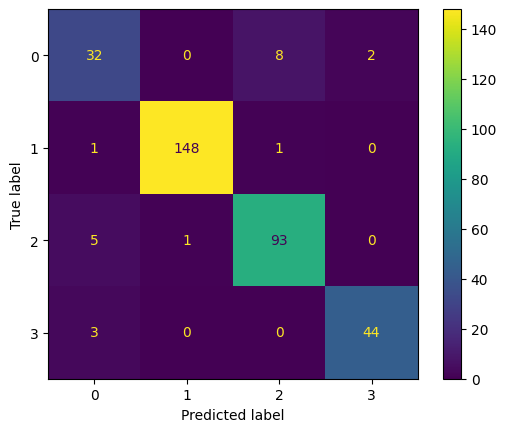

In [59]:
y_test_array = y_test.values
y_pred_array = y_pred_initial
cm = confusion_matrix(y_test_array, y_pred_array, labels=svc_initial_model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=svc_initial_model.classes_)
disp.plot()

In [60]:
svc_cross_val_model = SVC(random_state=42)
hyperparameters_svc = {
    'C': [0.1, 1, 10],            # Regularization parameter
    'kernel': ['linear', 'rbf'],  # Kernel type
    'gamma': ['scale', 'auto']    # Kernel coefficient
}

stratified_kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

In [61]:
svc_best_models_list = []
for train_index, test_index in stratified_kfold.split(df_normalized_80_percent, df_normalized_80_percent['Category_type_encoded']):
    np.random.shuffle(train_index)
    np.random.shuffle(test_index)
    X_train1, X_test1 = df_normalized_80_percent.iloc[train_index], df_normalized_80_percent.iloc[test_index]
    y_train1, y_test1 = X_train1['Category_type_encoded'], X_test1['Category_type_encoded']
    X_train1, X_test1 = X_train1.drop('Category_type_encoded', axis=1), X_test1.drop('Category_type_encoded', axis=1)
    grid_search = GridSearchCV(
        svc_cross_val_model,
        hyperparameters_svc,
        scoring='f1_weighted',
        cv=5
    )
    grid_search.fit(X_train1, y_train1)
    best_model = grid_search.best_estimator_
    best_model.fit(X_train1, y_train1)
    train_accuracy = best_model.score(X_train1, y_train1)
    test_accuracy = best_model.score(X_test1, y_test1)
    y_pred1 = best_model.predict(X_test1)
    weighted_f1_scores = f1_score(y_test1, y_pred1, average='weighted')
    result_dict = {
        "best_model": best_model,
        "train_accuracy": train_accuracy,
        "test_accuracy": test_accuracy,
        "weighted_f1_scores": weighted_f1_scores,
        "best_hyperparameters": grid_search.best_params_
    }
    svc_best_models_list.append(result_dict)

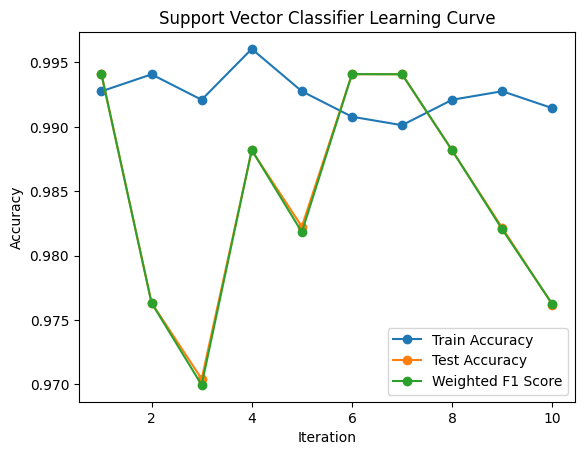

In [62]:
svc_train_accuracies = [res_dic["train_accuracy"] for res_dic in svc_best_models_list]
svc_test_accuracies = [res_dic["test_accuracy"] for res_dic in svc_best_models_list]
svc_weighted_f1_scores = [res_dic["weighted_f1_scores"] for res_dic in svc_best_models_list]

plt.plot(range(1, len(svc_best_models_list) + 1), svc_train_accuracies, marker='o', label='Train Accuracy')
plt.plot(range(1, len(svc_best_models_list) + 1), svc_test_accuracies, marker='o', label='Test Accuracy')
plt.plot(range(1, len(svc_best_models_list) + 1), svc_weighted_f1_scores, marker='o', label='Weighted F1 Score')
plt.title('Support Vector Classifier Learning Curve')
plt.xlabel('Iteration')
plt.ylabel('Accuracy')
plt.legend()

In [63]:
svc_best_models_list

[{'best_model': SVC(C=10, kernel='linear', random_state=42),
  'train_accuracy': 0.9927583936800527,
  'test_accuracy': 0.9940828402366864,
  'weighted_f1_scores': 0.9940828402366864,
  'best_hyperparameters': {'C': 10, 'gamma': 'scale', 'kernel': 'linear'}},
 {'best_model': SVC(C=10, kernel='linear', random_state=42),
  'train_accuracy': 0.9940750493745886,
  'test_accuracy': 0.9763313609467456,
  'weighted_f1_scores': 0.9763204883929647,
  'best_hyperparameters': {'C': 10, 'gamma': 'scale', 'kernel': 'linear'}},
 {'best_model': SVC(C=10, kernel='linear', random_state=42),
  'train_accuracy': 0.9921000658327848,
  'test_accuracy': 0.9704142011834319,
  'weighted_f1_scores': 0.9699486750071,
  'best_hyperparameters': {'C': 10, 'gamma': 'scale', 'kernel': 'linear'}},
 {'best_model': SVC(C=10, kernel='linear', random_state=42),
  'train_accuracy': 0.9960500329163924,
  'test_accuracy': 0.9881656804733728,
  'weighted_f1_scores': 0.9881996140060657,
  'best_hyperparameters': {'C': 10, 'ga

In [64]:
best_svc_model_pred = (svc_best_models_list[svc_weighted_f1_scores.index(max(svc_weighted_f1_scores))]["best_model"]).predict(
    df_normalized_20_percent.drop("Category_type_encoded", axis=1))


In [65]:
print("Accuracy:", accuracy_score(df_normalized_20_percent["Category_type_encoded"], best_svc_model_pred))
print(classification_report(df_normalized_20_percent["Category_type_encoded"], best_svc_model_pred))

Accuracy: 0.9810874704491725
              precision    recall  f1-score   support

           0       0.97      0.94      0.95        62
           1       0.99      1.00      0.99       199
           2       0.97      0.97      0.97       106
           3       0.98      0.98      0.98        56

    accuracy                           0.98       423
   macro avg       0.98      0.97      0.97       423
weighted avg       0.98      0.98      0.98       423



## KNN 

In [66]:
knn_initial_model = KNeighborsClassifier()
knn_initial_model.fit(X_train, y_train)
knn_y_pred_initial = knn_initial_model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, knn_y_pred_initial))
print(classification_report(y_test, knn_y_pred_initial))


Accuracy: 0.8816568047337278
              precision    recall  f1-score   support

           0       0.73      0.38      0.50        42
           1       0.94      1.00      0.97       150
           2       0.86      0.90      0.88        99
           3       0.80      0.91      0.85        47

    accuracy                           0.88       338
   macro avg       0.83      0.80      0.80       338
weighted avg       0.87      0.88      0.87       338



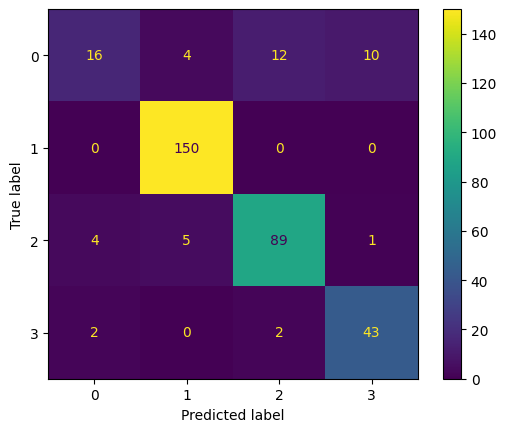

In [67]:
y_test_array = y_test.values
y_pred_array = knn_y_pred_initial
cm = confusion_matrix(y_test_array, y_pred_array, labels=knn_initial_model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=knn_initial_model.classes_)
disp.plot()

In [68]:
knn_cross_val_model = KNeighborsClassifier()
hyperparameters_knn = {
    'n_neighbors': [3, 5, 7],
    'weights': ['uniform', 'distance'],
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
    'p': [1, 2]
}
stratified_kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

In [69]:
Knn_best_models_list = []
for train_index, test_index in stratified_kfold.split(df_normalized_80_percent, df_normalized_80_percent['Category_type_encoded']):
    np.random.shuffle(train_index)
    np.random.shuffle(test_index)
    X_train1, X_test1 = df_normalized_80_percent.iloc[train_index], df_normalized_80_percent.iloc[test_index]
    y_train1, y_test1 = X_train1['Category_type_encoded'], X_test1['Category_type_encoded']
    X_train1, X_test1 = X_train1.drop('Category_type_encoded', axis=1), X_test1.drop('Category_type_encoded', axis=1)
    grid_search = GridSearchCV(
        knn_initial_model,
        hyperparameters_knn,
        scoring='f1_weighted',
        cv=5
    )
    grid_search.fit(X_train1, y_train1)
    best_model = grid_search.best_estimator_
    best_model.fit(X_train1, y_train1)
    train_accuracy = best_model.score(X_train1, y_train1)
    test_accuracy = best_model.score(X_test1, y_test1)
    y_pred1 = best_model.predict(X_test1)
    weighted_f1_scores = f1_score(y_test1, y_pred1, average='weighted')
    result_dict = {
        "best_model": best_model,
        "train_accuracy": train_accuracy,
        "test_accuracy": test_accuracy,
        "weighted_f1_scores": weighted_f1_scores,
        "best_hyperparameters": grid_search.best_params_
    }
    Knn_best_models_list.append(result_dict)

In [70]:
Knn_best_models_list

[{'best_model': KNeighborsClassifier(n_neighbors=3, p=1, weights='distance'),
  'train_accuracy': 1.0,
  'test_accuracy': 0.9467455621301775,
  'weighted_f1_scores': 0.945806568921536,
  'best_hyperparameters': {'algorithm': 'auto',
   'n_neighbors': 3,
   'p': 1,
   'weights': 'distance'}},
 {'best_model': KNeighborsClassifier(n_neighbors=3, p=1, weights='distance'),
  'train_accuracy': 1.0,
  'test_accuracy': 0.834319526627219,
  'weighted_f1_scores': 0.82806306189279,
  'best_hyperparameters': {'algorithm': 'auto',
   'n_neighbors': 3,
   'p': 1,
   'weights': 'distance'}},
 {'best_model': KNeighborsClassifier(n_neighbors=3, p=1),
  'train_accuracy': 0.9519420671494404,
  'test_accuracy': 0.8994082840236687,
  'weighted_f1_scores': 0.9001902811920903,
  'best_hyperparameters': {'algorithm': 'auto',
   'n_neighbors': 3,
   'p': 1,
   'weights': 'uniform'}},
 {'best_model': KNeighborsClassifier(n_neighbors=3, p=1, weights='distance'),
  'train_accuracy': 1.0,
  'test_accuracy': 0.8994

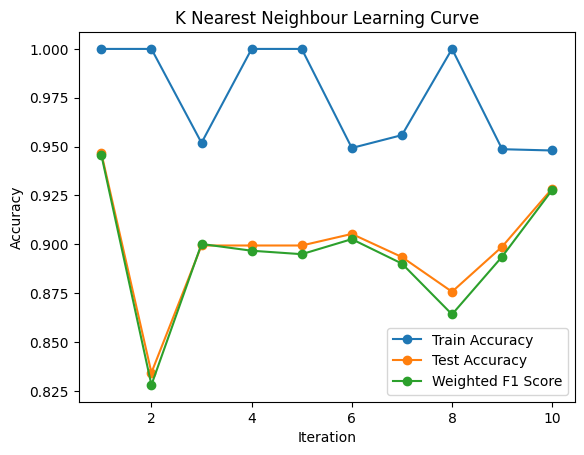

In [71]:
knn_train_accuracies = [res_dic["train_accuracy"] for res_dic in Knn_best_models_list]
knn_test_accuracies = [res_dic["test_accuracy"] for res_dic in Knn_best_models_list]
knn_weighted_f1_scores = [res_dic["weighted_f1_scores"] for res_dic in Knn_best_models_list]

plt.plot(range(1, len(Knn_best_models_list) + 1), knn_train_accuracies, marker='o', label='Train Accuracy')
plt.plot(range(1, len(Knn_best_models_list) + 1), knn_test_accuracies, marker='o', label='Test Accuracy')
plt.plot(range(1, len(Knn_best_models_list) + 1), knn_weighted_f1_scores, marker='o', label='Weighted F1 Score')
plt.title('K Nearest Neighbour Learning Curve')
plt.xlabel('Iteration')
plt.ylabel('Accuracy')
plt.legend()

In [72]:
best_knn_model_pred = (Knn_best_models_list[knn_weighted_f1_scores.index(max(knn_weighted_f1_scores))]["best_model"]).predict(df_normalized_20_percent.drop("Category_type_encoded", axis =1))

In [73]:
print("Accuracy:", accuracy_score(df_normalized_20_percent["Category_type_encoded"], best_knn_model_pred))
print(classification_report(df_normalized_20_percent["Category_type_encoded"], best_knn_model_pred))

Accuracy: 0.9030732860520094
              precision    recall  f1-score   support

           0       0.83      0.56      0.67        62
           1       0.97      0.98      0.98       199
           2       0.84      0.92      0.88       106
           3       0.86      0.96      0.91        56

    accuracy                           0.90       423
   macro avg       0.87      0.86      0.86       423
weighted avg       0.90      0.90      0.90       423



Chat GPT 3.5 Turbo

In [74]:
openai.api_key = config.api_key

In [75]:

encoding = {
    "normal_weight" : 0,
    "obesity" : 1,
    "overweight" : 2,
    "underweight" : 3
}

In [76]:

test_df = pd.read_csv("./test_data.csv")

test_df["category_encoding"] = test_df["Category_type"].map(encoding)

In [77]:
predicted_output = []
with open("obesity_test.jsonl", "r") as f:
    for line in f:
        data = json.loads(line)
        messages = data["messages"]
        response = openai.chat.completions.create(
            model="ft:gpt-3.5-turbo-0613:personal::8SBEArVW",
            messages=messages,
        )
        predicted_output.append(response)

In [78]:
AI_fine_tuned_pred = []
for response in predicted_output :
    if "normal" in ((response.choices[0]).message.content).lower():
        AI_fine_tuned_pred.append(0)
    elif "overweight" in ((response.choices[0]).message.content).lower():
        AI_fine_tuned_pred.append(2)
    elif "obes" in ((response.choices[0]).message.content).lower():
        AI_fine_tuned_pred.append(1)
    elif "underweight" in ((response.choices[0]).message.content).lower():
        AI_fine_tuned_pred.append(3)
    else:
        AI_fine_tuned_pred.append((response.choices[0]).message.content)


In [79]:
print(test_df["category_encoding"].values, len(test_df["category_encoding"].values))


[3 1 3 3 0 3 1 2 1 3 1 1 1 1 1 2 1 1 1 2 1 2 1 1 0 2 2 1 1 3 1 2 2 0 3 1 1
 0 0 0 0 1 0 0 2 3 1 0 1 1 0 0 0 2 3 2 1 1 2 1 0 1 2 3 1 1 0 1 3 0 2 2 3 3
 2 1 1 0 1 1 0 1 1 1 1 1 0 2 0 2 2 1 3 2 1 3 2 1 0 1 1 1 1 1 2 1 0 1 1 1 1
 0 1 0 3 1 1 1 2 0 1 1 1 2 0 1 1 1 1 1 1 1 0 1 2 1 3 1 2 1 2 2 3 3 0 1 1 1
 3 1 3 3 0 1 1 2 2 2 3 3 0 0 1 3 1 3 1 0 2 2 0 2 1 1 1 2 1 2 1 2 3 1 3 2 1
 1 2 1 1 1 3 1 3 0 1 2 1 1 1 3 1 1 1 1 0 1 2 2 1 1 2 1 3 1 1 3 2 1 1 1 1 2
 1 2 1 2 3 1 2 2 2 1 0 2 0 1 1 1 1 3 2 2 2 1 1 1 0 1 1 3 2 1 3 0 0 2 1 1 1
 1 1 1 2 1 1 1 1 0 0 1 1 1 2 1 1 1 1 1 1 0 3 2 2 1 1 2 1 2 3 1 1 2 0 1 3 2
 1 1 2 2 0 2 3 3 2 0 2 2 2 1 2 1 0 1 2 2 1 1 2 0 3 0 1 3 0 1 1 1 1 3 0 0 1
 1 1 2 1 3 3 3 1 1 2 1 1 1 2 1 2 2 2 1 2 0 3 2 2 2 2 2 2 1 1 1 1 1 1 2 2 1
 3 1 0 1 1 2 3 0 1 1 2 2 0 3 1 2 1 1 0 1 1 2 1 2 1 2 3 1 2 1 0 3 0 2 1 0 3
 1 0 1 2 2 2 2 1 3 2 1 2 1 0 1 2] 423


In [80]:
print(AI_fine_tuned_pred, len(AI_fine_tuned_pred))


[3, 1, 3, 3, 0, 3, 1, 2, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 0, 2, 2, 1, 1, 3, 1, 2, 2, 0, 3, 1, 1, 0, 0, 0, 0, 1, 0, 0, 2, 3, 1, 0, 1, 1, 2, 0, 0, 2, 3, 2, 1, 1, 2, 1, 0, 1, 2, 3, 1, 1, 0, 1, 3, 0, 2, 1, 3, 3, 2, 1, 1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 0, 2, 0, 2, 2, 1, 3, 2, 1, 3, 2, 1, 2, 1, 1, 1, 1, 1, 2, 1, 0, 1, 1, 1, 1, 0, 1, 0, 3, 1, 1, 1, 2, 2, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 0, 1, 2, 1, 3, 1, 2, 1, 2, 2, 3, 3, 0, 1, 1, 1, 3, 1, 3, 3, 0, 1, 1, 2, 1, 2, 3, 3, 2, 0, 1, 3, 1, 3, 1, 2, 2, 2, 0, 1, 1, 1, 1, 2, 1, 2, 1, 2, 3, 1, 3, 2, 1, 1, 2, 1, 1, 1, 3, 1, 3, 0, 1, 2, 1, 1, 1, 3, 1, 1, 1, 1, 0, 1, 2, 2, 1, 1, 2, 1, 3, 1, 1, 3, 2, 1, 1, 1, 1, 2, 1, 2, 1, 2, 3, 1, 2, 2, 2, 1, 0, 2, 0, 1, 1, 1, 1, 3, 2, 2, 2, 1, 1, 1, 0, 1, 1, 3, 2, 1, 3, 0, 0, 2, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 2, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 3, 3, 2, 2, 1, 1, 2, 1, 2, 3, 1, 1, 2, 3, 1, 3, 2, 1, 1, 2, 1, 0, 2, 3, 3, 2, 2, 2, 2, 2, 1, 2, 1, 0, 1, 2, 2, 1, 1, 2, 0, 3, 2, 1, 3, 0, 1, 1, 1, 1, 3, 0, 0, 1, 

In [81]:
accuracy_score(test_df["category_encoding"].values, AI_fine_tuned_pred)

0.9479905437352246

In [82]:
confusion_matrix(test_df["category_encoding"].values, AI_fine_tuned_pred)

array([[ 46,   0,  13,   3],
       [  0, 199,   0,   0],
       [  0,   6, 100,   0],
       [  0,   0,   0,  56]])

In [83]:
print(classification_report(test_df["category_encoding"].values, AI_fine_tuned_pred))

              precision    recall  f1-score   support

           0       1.00      0.74      0.85        62
           1       0.97      1.00      0.99       199
           2       0.88      0.94      0.91       106
           3       0.95      1.00      0.97        56

    accuracy                           0.95       423
   macro avg       0.95      0.92      0.93       423
weighted avg       0.95      0.95      0.95       423



Now lets use all best models from all algorithm types and combine those into a Dataframe.

In [84]:
best_decison_tree_model = decision_tree_best_models_list[max_f1_score_index]["best_model"]

In [85]:
random_forest_best_model = random_forest_best_models_list[random_forest_weighted_f1_scores.index(max(random_forest_weighted_f1_scores))]["best_model"]

In [86]:
svc_best_model = svc_best_models_list[svc_weighted_f1_scores.index(max(svc_weighted_f1_scores))]["best_model"]

In [87]:
knn_best_model = Knn_best_models_list[knn_weighted_f1_scores.index(max(knn_weighted_f1_scores))]["best_model"]

In [88]:
All_models_prediction = pd.DataFrame()

In [89]:
df_normalized_20_percent.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 423 entries, 544 to 1103
Data columns (total 32 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   Age                                 423 non-null    float64
 1   Height                              423 non-null    float64
 2   Weight                              423 non-null    float64
 3   FCVC                                423 non-null    float64
 4   NCP                                 423 non-null    float64
 5   CH2O                                423 non-null    float64
 6   FAF                                 423 non-null    float64
 7   TUE                                 423 non-null    float64
 8   Category_type_encoded               423 non-null    int8   
 9   Gender_Female                       423 non-null    uint8  
 10  Gender_Male                         423 non-null    uint8  
 11  family_history_with_overweight_no   423 no

In [90]:
All_models_prediction["Decision_Tree"] = best_decison_tree_model.predict(df_normalized_20_percent.drop("Category_type_encoded", axis=1))
All_models_prediction["Random_Forest"] = random_forest_best_model.predict(df_normalized_20_percent.drop("Category_type_encoded", axis=1))
All_models_prediction["Support_Vector_Classifier"] = svc_best_model.predict(df_normalized_20_percent.drop("Category_type_encoded", axis=1))
All_models_prediction["K_Nearest"] = knn_best_model.predict(df_normalized_20_percent.drop("Category_type_encoded", axis=1))


In [91]:
All_models_prediction["GPT_3.5_fine_tune"] = AI_fine_tuned_pred

In [92]:
All_models_prediction.head()

Decision_Tree  Random_Forest  Support_Vector_Classifier  K_Nearest  \
0              3              3                          3          3   
1              1              1                          1          1   
2              3              3                          3          3   
3              3              3                          3          3   
4              0              2                          0          2   

   GPT_3.5_fine_tune  
0                  3  
1                  1  
2                  3  
3                  3  
4                  0

In [93]:
All_models_prediction["Ensemble_pred"] = (All_models_prediction.mode(axis =1)[0]).astype("int")

In [94]:
All_models_prediction["original"] = df_normalized_20_percent["Category_type_encoded"].reset_index(drop=True)

In [95]:
accuracy_score(All_models_prediction["original"],All_models_prediction["Ensemble_pred"])

0.9810874704491725

In [97]:
print(classification_report(All_models_prediction["original"],All_models_prediction["Ensemble_pred"]))

              precision    recall  f1-score   support

           0       1.00      0.87      0.93        62
           1       1.00      1.00      1.00       199
           2       0.94      1.00      0.97       106
           3       0.98      1.00      0.99        56

    accuracy                           0.98       423
   macro avg       0.98      0.97      0.97       423
weighted avg       0.98      0.98      0.98       423

